In [1]:
# the following code is based on code provided in the article
# https://towardsdatascience.com/facial-keypoints-detection-deep-learning-737547f73515
# I have converted it into pytorch however because I prefer pytorch

In [1]:
import random
import math

import numpy as np
import pandas as pd
import cv2

import matplotlib.pyplot as plt

import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms, models

In [2]:
seed = 0
torch.manual_seed(seed)
if torch.cuda.is_available():
    print("cuda avaiable")
    torch.cuda.manual_seed(seed)
    torch.device('cuda')

cuda avaiable


In [3]:
test_csv = pd.read_csv('data/test.csv')
train_csv = pd.read_csv('data/training.csv')

train_csv['Image'] = train_csv['Image'].apply(lambda im: np.fromstring(im, sep=' '))
test_csv['Image'] = test_csv['Image'].apply(lambda im: np.fromstring(im, sep=' '))
train_csv = train_csv.dropna()
test_csv = test_csv.dropna()

### Load the train and test data into a pytorch-friendly format

In [4]:
#display(train_csv)

X_train = np.vstack(train_csv['Image'].values) / 255
X_train = torch.tensor(X_train).float()
X_train = X_train.reshape(-1, 1, 96, 96)

y_train = train_csv[train_csv.columns[:-1]].values
y_train = (y_train - 48) / 48
y_train = torch.tensor(y_train).float()

X_test = np.vstack(test_csv['Image'].values) / 255
X_test = torch.tensor(X_test).float()
X_test = X_test.reshape(-1, 1, 96, 96)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)


torch.Size([2140, 1, 96, 96])
torch.Size([2140, 30])
torch.Size([1783, 1, 96, 96])


### Perform random transformation on the images

In [5]:
image_number = 1002

all_rotated_features = []
all_rotated_images = []

for original_image, original_features in list(zip(X_train, y_train)):
    
    #create the random rotation matrix for the attributes
    theta = random.random() * 3 - 1.5 #random rotation between -1.5 and 1.5 radians
    c, s = np.cos(-theta), np.sin(-theta)
    feature_rotator = np.array(((c, -s), (s, c)))

    #get the features from the original image and rotate them
    features = original_features.reshape(15, 2)
    rotated_features = np.dot(feature_rotator, features.T).T
    rotated_features = rotated_features * 48 + 48

    #get the original image and rotate it
    image = original_image.reshape(96, 96)
    image = image.numpy()
    image_rotator = cv2.getRotationMatrix2D((48, 48), np.degrees(theta), 1.0)
    rotated_image = cv2.warpAffine(image, image_rotator, image.shape[1::-1], flags=cv2.INTER_LINEAR)

    #transform the features into a format consistant with the original data
    rotated_features = rotated_features.flatten()
    rotated_features = (rotated_features - 48) / 48
    rotated_features = torch.tensor(rotated_features).float()

    #transform the images into a format consistant with the original data
    rotated_image = np.vstack(rotated_image)
    rotated_image = torch.tensor(rotated_image).float()
    rotated_image = rotated_image.reshape(1, 96, 96)

    all_rotated_features.append(rotated_features)
    all_rotated_images.append(rotated_image)
    
print(rotated_features.shape)
print(rotated_image.shape)

#append the modifed data to the original data
rotated_images = torch.stack(all_rotated_images)
rotated_features = torch.stack(all_rotated_features)

print(X_train.shape)
print(y_train.shape)



torch.Size([30])
torch.Size([1, 96, 96])
torch.Size([2140, 1, 96, 96])
torch.Size([2140, 30])


### Perform random scaling

In [6]:
all_translated_images = []
all_translated_features = []

for original_image, original_features in list(zip(X_train, y_train)):

    scale = random.uniform(0.6, 1.0)
    dsize = (math.ceil(96 * scale), math.ceil(96 * scale))

    #scale features
    features = original_features.reshape(15, 2).numpy()
    features = features * 48 + 48
    features = features * scale

    features_count = features.shape[0]

    #scale image
    image = original_image.reshape(96, 96).numpy()
    scaled_image = cv2.resize(image, dsize)

    scale_height, scale_width = scaled_image.shape

    top_left_image = np.zeros((96, 96))
    top_right_image = np.zeros((96, 96))
    bottom_left_image = np.zeros((96, 96))
    bottom_right_image = np.zeros((96, 96))

    top_left_features = np.repeat([[0,                    0]],               features_count, axis=0) + features
    top_right_features = np.repeat([[96 - scale_width,    0]],               features_count, axis=0) + features
    bottom_left_features = np.repeat([[0,                 96-scale_height]], features_count, axis=0) + features
    bottom_right_features = np.repeat([[96 - scale_width, 96-scale_height]], features_count, axis=0) + features

    top_left_image[0:scale_height, 0:scale_width] = scaled_image
    top_right_image[0:scale_height, (96 - scale_width):96] = scaled_image
    bottom_left_image[(96-scale_height):96, 0:scale_width] = scaled_image
    bottom_right_image[(96-scale_height):96, (96 - scale_width):96] = scaled_image
    
    top_left_features = (torch.tensor(top_left_features.flatten()) - 48 ) / 48
    top_right_features = (torch.tensor(top_right_features.flatten()) - 48 ) / 48
    bottom_left_features = (torch.tensor(bottom_left_features.flatten()) - 48 ) / 48
    bottom_right_features = (torch.tensor(bottom_right_features.flatten()) - 48 ) / 48

    top_left_image = torch.tensor(top_left_image).reshape(1, 96, 96)
    top_right_image = torch.tensor(top_right_image).reshape(1, 96, 96)
    bottom_left_image = torch.tensor(bottom_left_image).reshape(1, 96, 96)
    bottom_right_image = torch.tensor(bottom_right_image).reshape(1, 96, 96)

    all_translated_features.append(top_left_features.float())
    all_translated_features.append(top_right_features.float())
    all_translated_features.append(bottom_left_features.float())
    all_translated_features.append(bottom_right_features.float())
    
    all_translated_images.append(top_left_image.float())
    all_translated_images.append(top_right_image.float())
    all_translated_images.append(bottom_left_image.float())
    all_translated_images.append(bottom_right_image.float())
                

translated_images = torch.stack(all_translated_images)
translated_features = torch.stack(all_translated_features)

print(translated_images.shape)
print(translated_features.shape)

#plt.imshow(bottom_left_image)
#plt.scatter(bottom_left_features[:, 0], bottom_left_features[:, 1], c='0')

torch.Size([8560, 1, 96, 96])
torch.Size([8560, 30])


### Perform random brightness adjustments

### Add random noise

In [7]:

X_train = torch.cat((X_train, rotated_images, translated_images))
y_train = torch.cat((y_train, rotated_features, translated_features))

if (torch.cuda.is_available()):
    print("Using cuda")
    X_train = X_train.cuda()
    y_train = y_train.cuda()
    #X_test = X_test.cuda()

print(X_train.shape)
print(y_train.shape)

trainset = torch.utils.data.DataLoader(list(zip(X_train, y_train)), batch_size=64, shuffle=True)


Using cuda
torch.Size([12840, 1, 96, 96])
torch.Size([12840, 30])


In [8]:
#resnet = torch.hub.load('pytorch/vision:v0.9.0', 'resnet18', pretrained=True)

resnet = models.resnet50(pretrained=True)
#resnet = resnet.cuda() if torch.cuda.is_available() else resnet
#resnet

In [9]:
#convert the split set into a form that can be used by the neural network more easily


class FacialFeatureDetectionNetwork(nn.Module):
    def __init__(self, resnet):
        super().__init__()
    
    
        self.conv1 = nn.Conv2d(1, 3, kernel_size=5)
        self.resnet = resnet
        self.resnet.fc = nn.Linear(2048, 2048)
        #self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        #self.conv3 = nn.Conv2d(64, 64, kernel_size=3)
        #self.conv4 = nn.Conv2d(64, 64, kernel_size=3)
        
        #self.pool1 = nn.AvgPool2d(4)
        
        #self.flat1 = nn.Flatten()
        
        self.drop1 = nn.Dropout(0.1)
        #self.drop2 = nn.Dropout(0.2)
        #self.drop3 = nn.Dropout(0.3)
        '''
        self.fc1 = nn.Linear(1024, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 256)
        self.fc4 = nn.Linear(256, 64)
        self.fc5 = nn.Linear(64, 30)
        '''
        self.fc1 = nn.Linear(2048, 30)

    
    def forward(self, x):
        
        x = F.leaky_relu(self.conv1(x))
        #x = self.pool1(x)
        
        x = self.resnet(x)

        #x = F.relu(self.conv2(x))
        #x = self.pool1(x)
        #x = self.drop1(x)
        
        #x = F.relu(self.conv3(x))
        #x = self.pool1(x)
        #x = self.drop2(x)
        
        #x = F.relu(self.conv4(x))
        #x = self.pool1(x)
        #x = self.drop3(x)
        
        #x = self.flat1(x)
        #x = self.pool1(x)
        
        x = self.drop1(x)
        
        x = self.fc1(x)
        #x = F.relu(self.fc2(x))
        #x = F.relu(self.fc3(x))
        #x = F.relu(self.fc4(x))
        #x = self.fc5(x)
        return x
    

net = FacialFeatureDetectionNetwork(resnet)

In [10]:
net = FacialFeatureDetectionNetwork(resnet)
if torch.cuda.is_available():
    print("Using cuda")
    net = net.cuda()

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0005)

for epoch in range(0, 100):
    for data in trainset: 
        X, y = data 
        net.zero_grad()

        #print(X.shape, y.shape)
        
        output = net(X)
        #print(output.shape)
        #print(output.reshape(-1, 1).shape)

        loss = F.mse_loss(output, y)
        loss.backward()

        #print(loss)

        optimizer.step() 
    print("finished epoch", epoch, loss)


Using cuda
finished epoch 0 tensor(0.0248, device='cuda:0', grad_fn=<MseLossBackward>)
finished epoch 1 tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward>)
finished epoch 2 tensor(0.0019, device='cuda:0', grad_fn=<MseLossBackward>)
finished epoch 3 tensor(0.0017, device='cuda:0', grad_fn=<MseLossBackward>)
finished epoch 4 tensor(0.0027, device='cuda:0', grad_fn=<MseLossBackward>)
finished epoch 5 tensor(0.0016, device='cuda:0', grad_fn=<MseLossBackward>)
finished epoch 6 tensor(0.0013, device='cuda:0', grad_fn=<MseLossBackward>)
finished epoch 7 tensor(0.0015, device='cuda:0', grad_fn=<MseLossBackward>)
finished epoch 8 tensor(0.0009, device='cuda:0', grad_fn=<MseLossBackward>)
finished epoch 9 tensor(0.0011, device='cuda:0', grad_fn=<MseLossBackward>)
finished epoch 10 tensor(0.0010, device='cuda:0', grad_fn=<MseLossBackward>)
finished epoch 11 tensor(0.0013, device='cuda:0', grad_fn=<MseLossBackward>)
finished epoch 12 tensor(0.0047, device='cuda:0', grad_fn=<MseLossBackward>

In [11]:
net = net.cpu()
y_test = net(X_train.cpu()[:20])


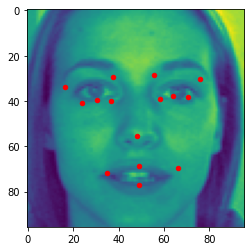

In [16]:

image_number = 9


image = X_test[image_number].reshape(96, 96)
image = image.numpy()
image = image * 255


features = y_test[image_number].reshape(15, 2)
features = features.detach().numpy()
features = features * 48 + 48


#print(image.shape)
#print(image)
#print(features)
plt.scatter(features[:, 0], features[:, 1], c='r', s=20)
plt.imshow(image)
